In [1]:
import os
import torch
import torch_geometric
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from brr import BRR

from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

from torch_geometric.nn import GCNConv
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dataset = Planetoid(root='data/Planetoid', name='pubmed', transform=NormalizeFeatures())
data = dataset[0].to(device)  # Get the first graph object.

In [2]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        # torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        return x

In [3]:
def train_gcn(eps, iterations):
    ldp = BRR(eps=eps, num_nodes=data.num_nodes, edge_index=data.edge_index)
    est_edge_index = ldp.get_est_edge_index()
    
    model = GCN(hidden_channels=16).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    def train():
        model.train()
        optimizer.zero_grad()  # Clear gradients.
        # out = model(data.x, get_est_edge_index())  # Perform a single forward pass.
        out = model(data.x, est_edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
        # val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients
        return float(loss)

    def test():
        model.eval()
        out = model(data.x, est_edge_index)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
        test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
        return test_acc
    
    log = np.zeros((iterations, 2))

    for epoch in range(1, iterations+1):
        loss = train()
        test_acc = test()
        log[epoch-1] = [loss, test_acc]
    
    return max(log[:,1])

In [4]:
res = {}
for eps in [0.01, 0.1, 1, 2, 4, 8]:
    acc = np.array([train_gcn(eps, 200) for _ in range(30)])
    res[eps] = [np.mean(acc), np.std(acc)]

RuntimeError: CUDA out of memory. Tried to allocate 1.45 GiB (GPU 0; 6.00 GiB total capacity; 4.39 GiB already allocated; 105.84 MiB free; 4.41 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
res

{0.01: [0.5668666666666666, 0.017289174519205787],
 0.1: [0.5683333333333334, 0.017240134054647648],
 1: [0.5686666666666668, 0.02256595272135039],
 2: [0.5747666666666665, 0.015374618333112803],
 4: [0.7740000000000001, 0.010082988974836126],
 8: [0.8199333333333332, 0.006722763981842241]}

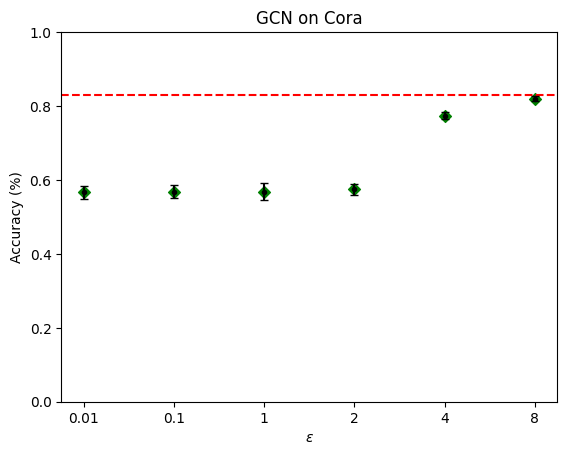

In [ ]:
fig = plt.figure()
# plt.axhline(y = 0.83, color = 'r', linestyle = '--')
plt.errorbar(["0.01", "0.1", "1", "2", "4", "8"], [res[i][0] for i in res], yerr=[res[i][1] for i in res], fmt='.k', capsize=3)
plt.scatter(["0.01", "0.1", "1", "2", "4", "8"], [res[i][0] for i in res], marker="D", color="green")

plt.ylim(ymin=0, ymax=1)
plt.xlabel("$\epsilon$")
plt.ylabel("Accuracy (%)")
plt.title("GCN on PubMed")
plt.savefig("pubmed.pdf", bbox_inches='tight')